In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
import plotly.io as pio
pio.renderers.default = "svg"

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
%%script false --no-raise-error
filename = "../../../pylec/studies/data/Synthetic.Household.Profiles.h5"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df = pd.read_hdf(filename, "TimeSeries")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    houseinfo = pd.read_hdf(filename, "HouseInfo")
mask = (houseinfo.Country == "France") & (houseinfo.Nmonths == "12")
df = df.loc[:, [str(a) for a in houseinfo[mask].pdIndex.tolist()]]

df["Index"] = pd.date_range(
    start="01-01-2019 00:00:00", end="31-12-2019 23:45:00", freq="15T"
)
df.set_index("Index", drop=True, inplace=True)

# --------------------------------------------
dateparse = lambda x: datetime.strptime(x, '%Y%m%d:%H%M')
pv = pd.read_csv("Timeseries_44.931_4.896_SA_1kWp_crystSi_14_38deg_-3deg_2014_2015.csv",
                 parse_dates=[0], index_col=[0], header=8, skipfooter=13, engine='python',
                 date_parser=dateparse)
# P is in W for a 1kW PV so we just have to change it to kW to get the coef 
pv = pv[['P']] / 1000
pv.columns = ["pv_1kw"]
pv = pv.loc['2014-01-01 00:00:00':'2015-01-01 00:10:00', :]

# Shifting things by 11 min, but whatever.
pv['Index'] = pd.date_range(start='2019-01-01 00:00:00',
                            end='2020-01-01 00:00:00', freq='60T')
pv.set_index('Index', drop=True, inplace=True)

# Interpolating to get 15-min interval values
pv = pv.resample('15T').interpolate('time')
pv.drop(pv.tail(1).index, inplace=True)

# --------------------------------------------
df["pv_1kw"] = pv["pv_1kw"]
df.to_pickle("fr_quoilin_data_valence.pickle")

In [3]:
df = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
df.head()

,2000900,2000901,2000903,2000904,2000905,2000906,2000907,2000908,2000909,2000910,...,2001188,2001189,2001190,2001192,2001193,2001194,2001195,2001197,2001199,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.295204,0.327625,0.483190,0.687899,0.143035,0.221557,0.224354,0.348925,2.359406,0.116382,...,0.079687,0.757643,0.080509,0.546715,0.026350,0.145583,0.160894,0.079701,1.420406,0.0
2019-01-01 00:15:00,0.223572,0.519240,0.236277,0.976978,0.178788,0.245871,0.485754,0.131845,1.064770,0.102974,...,0.269552,1.211409,0.074367,0.528931,0.057051,0.128810,0.155660,0.113194,0.641011,0.0
2019-01-01 00:30:00,0.237445,0.397812,0.151005,0.742844,0.232710,0.277901,0.594242,0.080997,0.897831,0.068910,...,0.107144,1.195561,0.083457,0.640498,0.069793,0.086199,0.188493,0.086067,0.540511,0.0
2019-01-01 00:45:00,0.477201,0.397999,0.398284,0.587097,0.285982,0.267720,0.512216,0.141001,1.433766,0.063750,...,0.165818,1.145802,0.107888,0.544124,0.060159,0.079745,0.160131,0.068022,0.863154,0.0
2019-01-01 01:00:00,0.415664,0.275134,0.108359,0.789470,0.181792,0.258787,0.185333,0.127379,1.140404,0.069257,...,0.250045,1.544101,0.036674,0.560161,0.031038,0.084432,0.178843,0.090153,0.814874,0.0


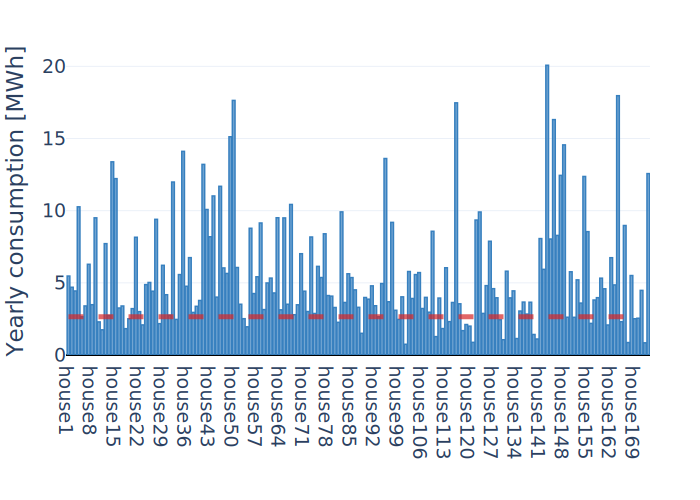

In [4]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house170",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

In [5]:
start = datetime(2019, 5, 28, 0, 0, 0)
end = start + timedelta(days=2)
individuals = df.loc[start:end, :].copy()

In [6]:
def community_bill(df, member_ids, prod_col, timing, deltat=15, buy_price=0.1740, exchange_price=0.0371):
    """Return cost for the community
    cost = buy [€/kWh] imports + pay fees on exchanges [€]
    """
    # Community import (sum then max)
    pos_netload = (
        (
            df[[a for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
            - df[[prod_col for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
        )
        .clip(lower=0)
        .sum()
        * deltat
        / 60
    )

    # Sum of ind import (max then sum)
    pos_n_netload = (
        sum(
            (df[a] - df[prod_col]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            for a in member_ids
        )
        * deltat
        / 60
    )

    return np.round(
        buy_price * pos_netload + exchange_price * (pos_n_netload - pos_netload), 3
    )

# Set optimization

In [7]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "glpk"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_energy(m, b):
            return m.batteryenergy[m.last, b] >= batteries[b]["end_kwh"]

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )

        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
        m.r6 = Constraint(m.batteries, rule=r_battery_end_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum(m.batteryin[i, b] for b in m.batteries)
                for i in m.horizon
            )

        m.objective = Objective(rule=objective_function, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, prod_col, spec):
        netloads = df.copy()
        for member_id in member_ids:
            netloads[member_id] -= df[prod_col]
        netloads.drop([prod_col], axis=1, inplace=True)
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec["min_kw"],
            "max_kw": spec["max_kw"],
            "max_kwh": spec["max_kwh"],
            "eta": spec["eta"],
            "offset": spec["offset"],
            "init_kwh": spec["max_kwh"] * spec["offset"],
            "end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

In [8]:
pv_size = 3
battery_size = 3
spec = {"min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "eta": 0.95,
        "offset": 0.01}
nb_house = 100

house_ids = list(individuals.columns[0:nb_house])

graph = individuals.loc[:, house_ids + ["pv_1kw"]].copy()
graph.pv_1kw *= pv_size

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371,
                          verbose=True, only_return_schedules=False)

schedule = model.solve(graph, house_ids, "pv_1kw", spec)


Problem: 
- Name: unknown
  Lower bound: 779.59816116973
  Upper bound: 779.59816116973
  Number of objectives: 1
  Number of constraints: 116294
  Number of variables: 77394
  Number of nonzeros: 251094
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 42.96114897727966
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



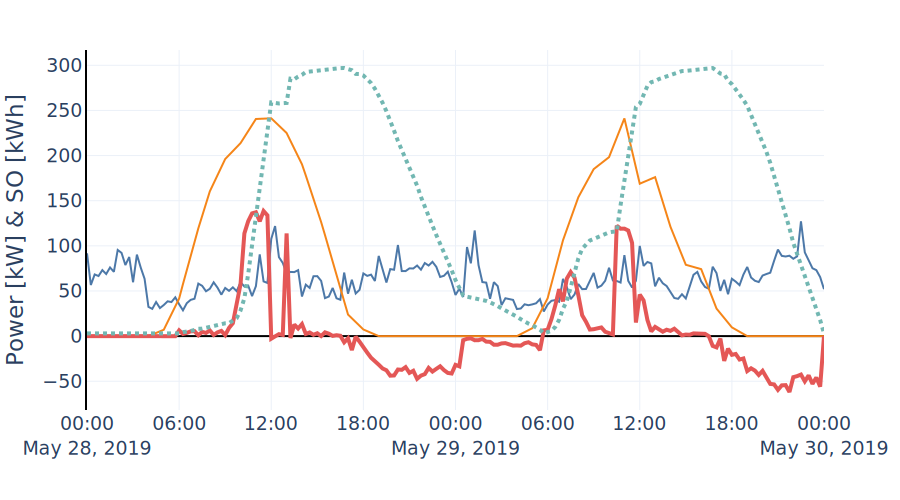

In [9]:
graph = individuals.loc[:, house_ids + ["pv_1kw"]].copy()
graph["community_kW"] = graph[house_ids].sum(axis=1)
graph.drop(house_ids, axis=1, inplace=True)

graph.pv_1kw *= nb_house * pv_size

graph["storage"] = schedule["schedules"].sum(axis=1)
graph["soc"] = schedule["batteryenergy"].sum(axis=1)


fig = px.line(graph.loc[start:end, :],
              y=["community_kW", "pv_1kw", "storage", "soc"])

fig.data[2].update(line_width=4)
fig.data[3].update(line_width=4, line_dash="dot")
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SO [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

# Scale !!!

In [10]:
from datetime import datetime

values = []
durations = []
pv_size = 3
battery_size = 5
spec = {"min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "eta": 0.95,
        "offset": 0.01}

nb_houses = list(range(2, 103, 10))
for nb_house in nb_houses:
    
    house_ids = list(individuals.columns[0:nb_house])

    graph = individuals.loc[:, house_ids + ["pv_1kw"]].copy()
    graph.pv_1kw *= pv_size
    
    # Start time
    start_time = datetime.now()
    
    model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371)
    schedule = model.solve(graph, house_ids, "pv_1kw", spec)
  
    # End time
    end_time = datetime.now()
    duration = end_time - start_time
    print(f"{nb_house}houses - {duration}")

    for house_id in house_ids:
        graph[house_id] += schedule[house_id]
    
    resultat = community_bill(graph, house_ids, prod_col="pv_1kw", timing="15T")
    values.append(resultat)
    durations.append(duration)

2houses - 0:00:00.322324
12houses - 0:00:01.923031
22houses - 0:00:04.927384
32houses - 0:00:08.270977
42houses - 0:00:13.356880
52houses - 0:00:18.662759
62houses - 0:00:26.525288
72houses - 0:00:34.403721
82houses - 0:00:44.918442
92houses - 0:00:56.717171
102houses - 0:01:10.509101


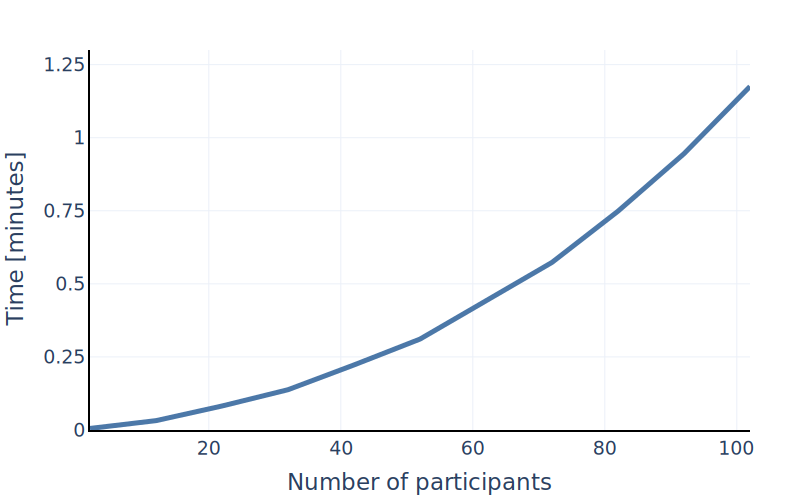

In [11]:
graph = pd.DataFrame(index=nb_houses, data=[a.total_seconds()/60 for a in durations])

_fig = px.line(graph)
_fig.data[-1].update(line_width=5)
_fig.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Time [minutes]",
    yaxis_dtick=0.25,
    xaxis_title="Number of participants",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=True, xaxis_linewidth=2, xaxis_linecolor='black',
    #xaxis_range=[0, x_limit],
    yaxis_range=[0, 1.3],
    showlegend=False,
    legend={"x": 0.02, "y": 1.015},
    legend_title="")
_fig.show()

In [18]:
_fig.write_image("results/scalability_2days.svg")